## Description:

    Ordinate enzyme data
    Regress axes against OTU abundance in DESeq


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [5]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [31]:
%%R

#remove BARE soil controls and untreated seeds
physeq.plant = subset_samples(physeq.Full, Genotype != "Bare" & SeedTreatment == "Treated")


# Remove ordination outliers, see Ordination notebook
#physeq.plant = subset_samples(physeq.plant, !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# Set rep as a factor
sample_data(physeq.plant)$Rep = factor(sample_data(physeq.plant)$Rep)   
sample_data(physeq.plant)$ERA = factor(sample_data(physeq.plant)$ERA)  
sample_data(physeq.plant)$Fert = factor(sample_data(physeq.plant)$Fert)  


physeq.plant


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 195 samples ]
sample_data() Sample Data:       [ 195 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


# Ordinate enzyme data - all timepoints

Importance of components:
                          PC1    PC2     PC3     PC4     PC5
Standard deviation     1.9195 0.8229 0.57399 0.47574 0.28760
Proportion of Variance 0.7369 0.1354 0.06589 0.04527 0.01654
Cumulative Proportion  0.7369 0.8723 0.93819 0.98346 1.00000
                     PC1         PC2         PC3        PC4         PC5
BG_activity.g  0.4537948  0.36833375 -0.12452155  0.7965710  0.09148531
BX_activity.g  0.4773930  0.00224410 -0.53658483 -0.4205482  0.55435264
CB_activity.g  0.4912365  0.22774799 -0.11289496 -0.3141920 -0.77159291
LAP_activity.g 0.3452099 -0.89889852 -0.01970263  0.2316418 -0.13698712
NAG_activity.g 0.4535229  0.06661471  0.82670287 -0.1903662  0.26495753


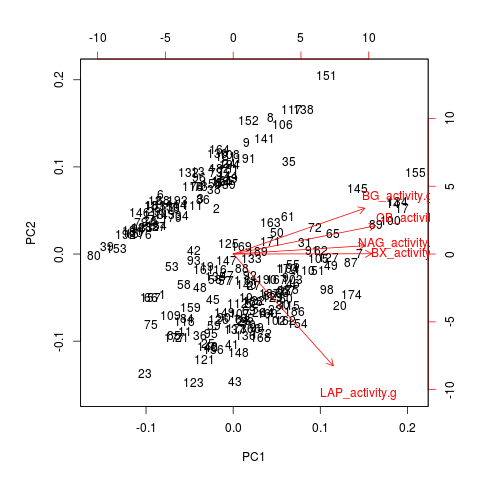

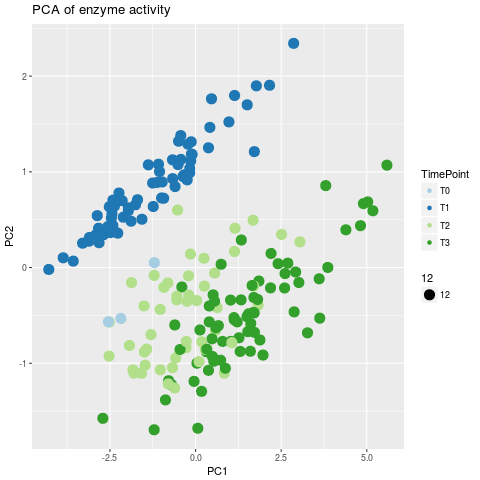

In [32]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant), "data.frame")
rownames(sd) = sd$X.sample

tmp = filter(sd, X.sampleID != "ERA-T1_4-5b_85")
fit = prcomp(~BG_activity.g + BX_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = tmp, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(tmp, S)
# rownames(TM_Fit) = TM_Fit$X.sample
# sample_data(physeq.plant) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, color = TimePoint, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p

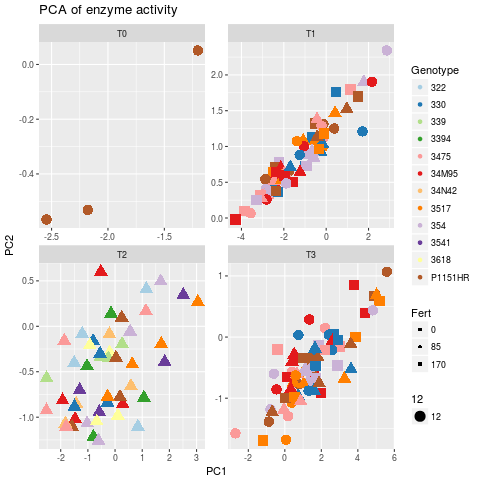

In [33]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Genotype, shape = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p = p + facet_wrap(~TimePoint, scales = "free")
p

### Join enzyme ordination scores with phyloseq object

In [34]:
%%R
PCscore = TM_Fit %>%
    select(X.sampleID, PC1, PC2, PC3)
colnames(PCscore)[2:4] = c("EnzPC1", "EnzPC2", "EnzPC3")

In [35]:
%%R
sd = left_join(sd, PCscore, by = "X.sampleID")
rownames(sd) = sd$X.sampleID
sample_data(physeq.plant) = sd

## DESeq of Enzymes

In [36]:
%%R
sample_data(physeq.plant)$Rep = as.factor(sample_data(physeq.plant)$Rep)
sample_data(physeq.plant)$Fert = as.factor(sample_data(physeq.plant)$Fert)
sample_data(physeq.plant)$ERA = as.factor(sample_data(physeq.plant)$ERA)
sample_data(physeq.plant)$R_Year.c = sample_data(physeq.plant)$R_Year - 1935

In [45]:
%%R
t.df = tax_table(physeq.plant) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [41]:
%%R
phyEnz = subset_samples(physeq.plant, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC1"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 105, 2.3% 
LFC < 0 (down)   : 71, 1.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 2048, 45% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


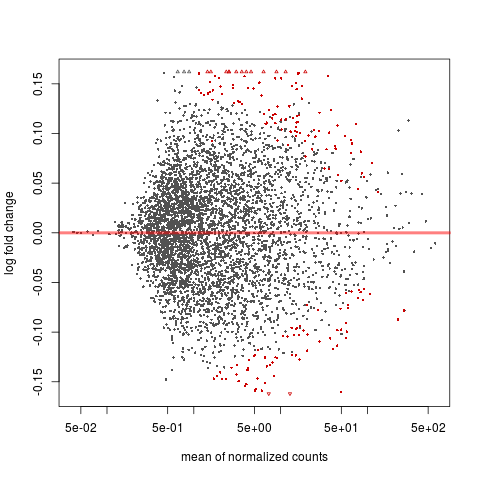

In [48]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [53]:
%%R
register(MulticoreParam(20))
phyEnz = subset_samples(physeq.plant, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC2"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 177, 3.9% 
LFC < 0 (down)   : 116, 2.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 1692, 37% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


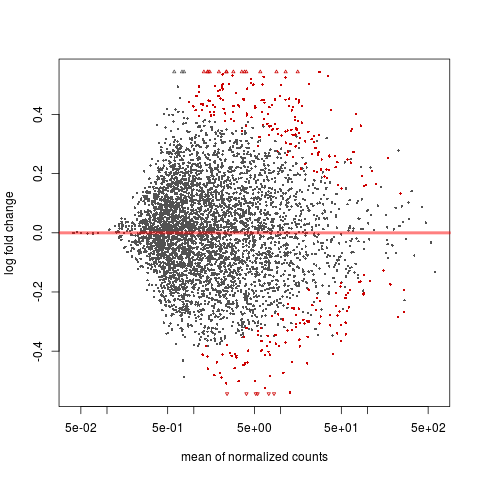

In [58]:
%%R
EnzRes2 = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes2) %>% print
plotMA(EnzRes2)

EnzRes2$OTU = rownames(EnzRes2)
df_pc2 = EnzRes2 %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [59]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

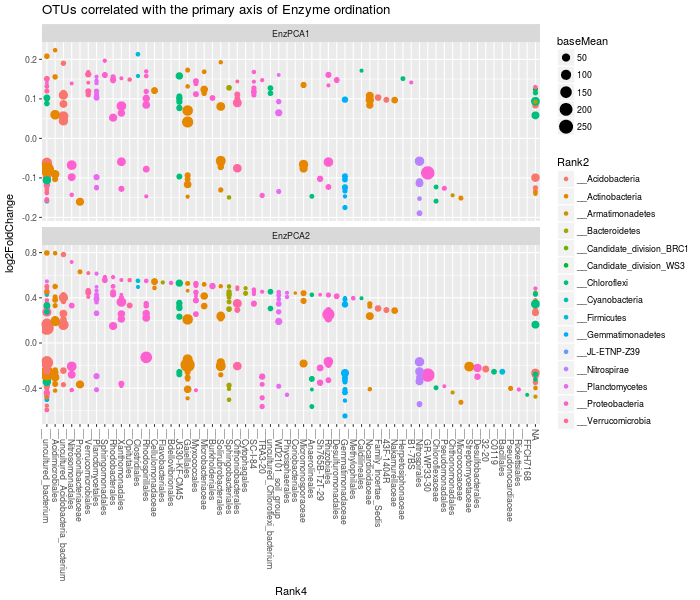

In [62]:
%%R -w 700 -h 600
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [64]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_EnzOrd_sig.csv', row.names = FALSE)

# Ordinate enzyme data - timepoints seperately

## T1

In [117]:
%%R
physeq.plant.t1 = subset_samples(physeq.plant, TimePoint == "T1")
physeq.plant.t1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4     PC5
Standard deviation     1.9397 0.8060 0.67485 0.32891 0.15577
Proportion of Variance 0.7525 0.1299 0.09109 0.02164 0.00485
Cumulative Proportion  0.7525 0.8824 0.97351 0.99515 1.00000
                     PC1        PC2         PC3         PC4          PC5
BG_activity.g  0.4024998  0.2426264 -0.87916706  0.02271460  0.075337192
BX_activity.g  0.4380164  0.5175566  0.36317248  0.63786686  0.038838709
CB_activity.g  0.4678560  0.3410311  0.28876996 -0.76250704  0.001885271
LAP_activity.g 0.4511513 -0.5791708  0.10549584  0.05938595  0.668107475
NAG_activity.g 0.4729787 -0.4706662  0.02556501  0.08755706 -0.739218987


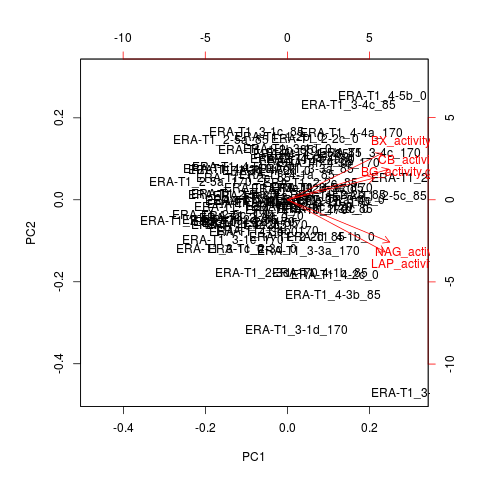

In [119]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t1), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + BX_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t1) = TM_Fit

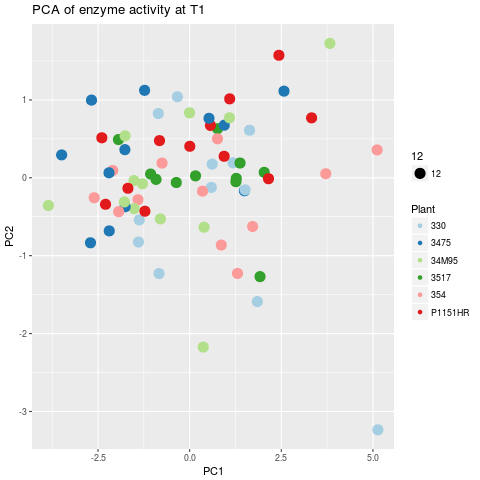

In [120]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T1")
p

## DESeq of T1 enzymes

In [121]:
%%R
sample_data(physeq.plant.t1)$Rep = as.factor(sample_data(physeq.plant.t1)$Rep)
sample_data(physeq.plant.t1)$Fert = as.factor(sample_data(physeq.plant.t1)$Fert)
sample_data(physeq.plant.t1)$ERA = as.factor(sample_data(physeq.plant.t1)$ERA)
sample_data(physeq.plant.t1)$R_Year.c = sample_data(physeq.plant.t1)$R_Year - 1935

In [123]:
%%R
t.df = tax_table(physeq.plant.t1) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [126]:
%%R
tmp.1 = subset_samples(physeq.plant.t1, !is.na(EnzPC1))
dds = phyloseq_to_deseq2(tmp.1, ~Rep + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC1"   



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 20, 0.44% 
LFC < 0 (down)   : 5, 0.11% 
outliers [1]     : 0, 0% 
low counts [2]   : 445, 9.7% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


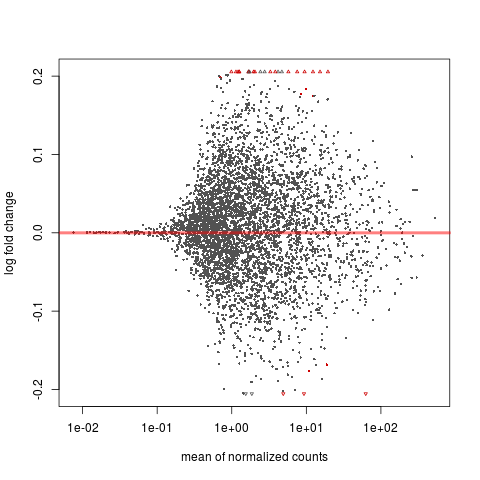

In [ ]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [ ]:
%%R

dds = phyloseq_to_deseq2(tmp.1, ~Rep + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC2"   



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 16, 0.35% 
LFC < 0 (down)   : 6, 0.13% 
outliers [1]     : 0, 0% 
low counts [2]   : 1777, 39% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


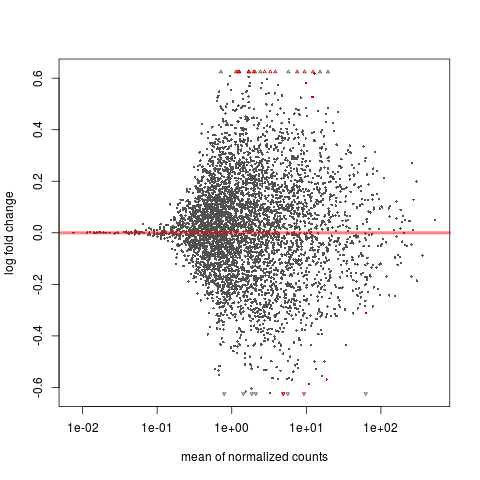

In [ ]:
%%R
EnzRes = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [ ]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

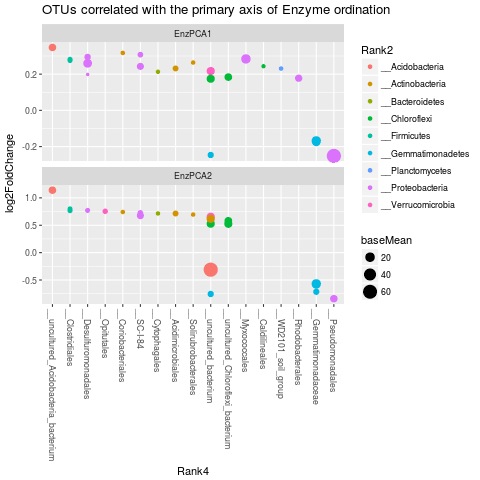

In [ ]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [132]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t1_sig.csv', row.names = FALSE)

## T2

In [106]:
%%R
physeq.plant.t2 = subset_samples(physeq.plant, TimePoint == "T2")
physeq.plant.t2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4     PC5
Standard deviation     1.8188 0.9846 0.69257 0.37825 0.31595
Proportion of Variance 0.6616 0.1939 0.09593 0.02861 0.01996
Cumulative Proportion  0.6616 0.8555 0.95142 0.98004 1.00000
                      PC1        PC2         PC3        PC4          PC5
BG_activity.g  -0.4046493  0.5642727 -0.47399120  0.5403699  0.034466534
BX_activity.g  -0.4971062 -0.3424434 -0.10690492 -0.1578104  0.774135110
CB_activity.g  -0.5117345  0.1676108 -0.19429690 -0.7015961 -0.424318271
LAP_activity.g -0.3951350 -0.6710392 -0.02037946  0.4168309 -0.468413617
NAG_activity.g -0.4136912  0.2931584  0.85190203  0.1308093  0.008341268


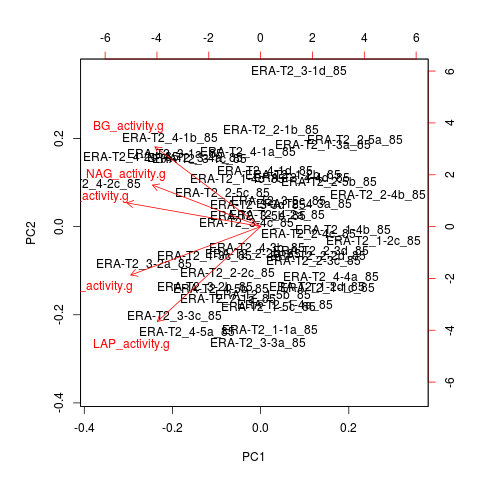

In [107]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t2), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + BX_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t2) = TM_Fit


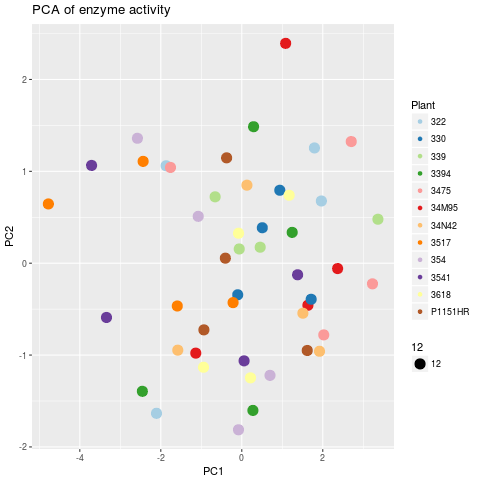

In [108]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p

## DESeq of T2 enzymes

In [109]:
%%R
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$ERA = as.factor(sample_data(physeq.plant.t2)$ERA)
sample_data(physeq.plant.t2)$R_Year.c = sample_data(physeq.plant.t2)$R_Year - 1935

In [110]:
%%R
t.df = tax_table(physeq.plant.t2) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [111]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t2, ~Rep + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC1"   



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 1, 0.022% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


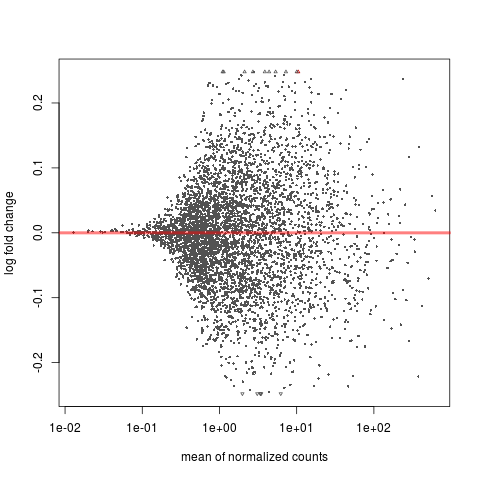

In [112]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [113]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t2, ~Rep + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC2"   



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 18, 0.39% 
LFC < 0 (down)   : 12, 0.26% 
outliers [1]     : 0, 0% 
low counts [2]   : 3469, 76% 
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


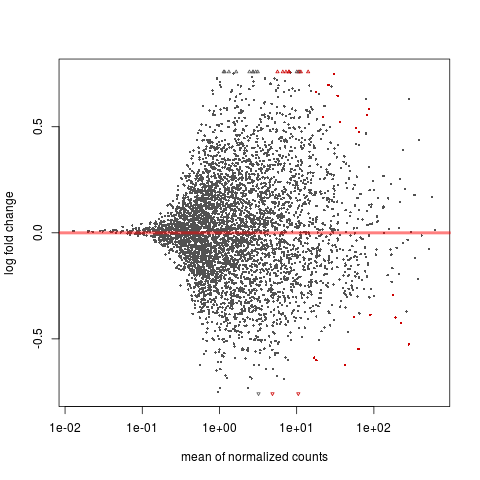

In [114]:
%%R
EnzRes = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [115]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

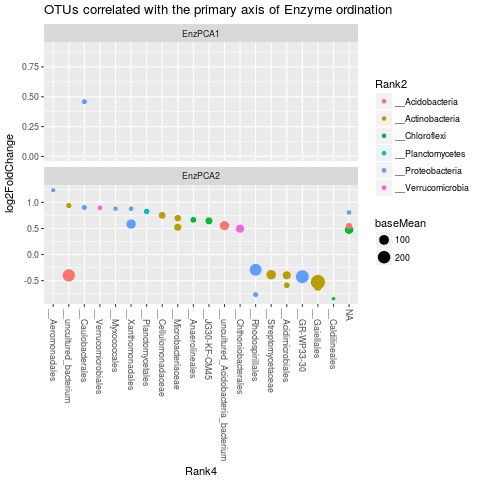

In [116]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [118]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t2_sig.csv', row.names = FALSE)

## Deseq of Enzyme ordination and MCC at T3

In [85]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
physeq.plant.t3

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4     PC5
Standard deviation     1.8374 1.0461 0.49675 0.43117 0.31171
Proportion of Variance 0.6752 0.2189 0.04935 0.03718 0.01943
Cumulative Proportion  0.6752 0.8940 0.94339 0.98057 1.00000
                      PC1         PC2         PC3         PC4        PC5
BG_activity.g  -0.5028177 -0.05191723  0.37428550 -0.75250538 -0.1952562
BX_activity.g  -0.4903304  0.23317664  0.41939314  0.61924256 -0.3819067
CB_activity.g  -0.5177640 -0.14824099  0.01392636  0.14791650  0.8293804
LAP_activity.g -0.2506953  0.81137872 -0.50676228 -0.14653308  0.0231626
NAG_activity.g -0.4193122 -0.51246701 -0.65346600  0.08320494 -0.3572310


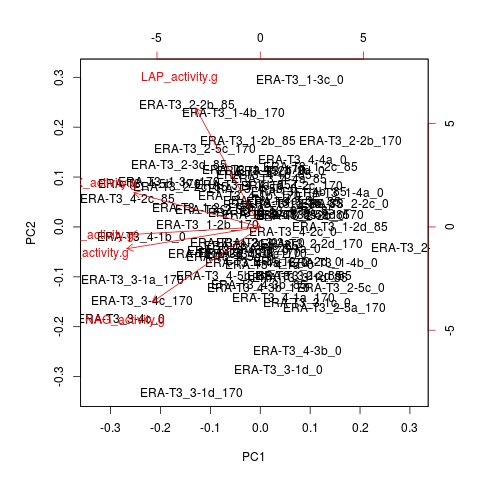

In [87]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t3), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + BX_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t3) = TM_Fit


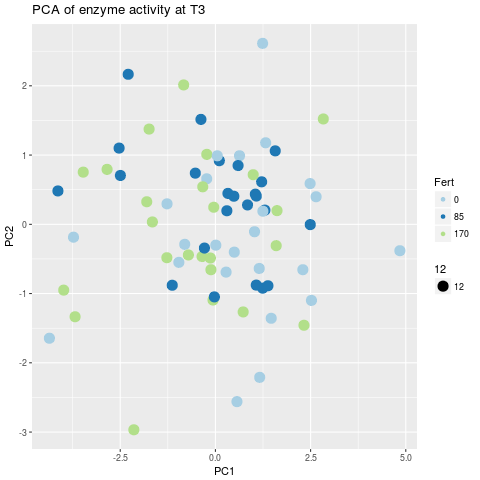

In [89]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T3") 
p

## DESeq of T3 enzymes

In [90]:
%%R
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$ERA = as.factor(sample_data(physeq.plant.t3)$ERA)
sample_data(physeq.plant.t3)$R_Year.c = sample_data(physeq.plant.t3)$R_Year - 1935

In [91]:
%%R
t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [92]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t3, ~Rep + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC1"   



out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 12, 0.26% 
LFC < 0 (down)   : 13, 0.28% 
outliers [1]     : 0, 0% 
low counts [2]   : 3470, 76% 
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


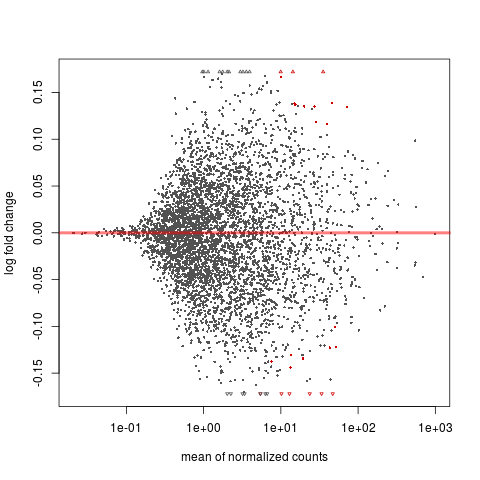

In [93]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [95]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t3, ~Rep + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "EnzPC2"   



out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 24, 0.52% 
LFC < 0 (down)   : 12, 0.26% 
outliers [1]     : 0, 0% 
low counts [2]   : 3025, 66% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


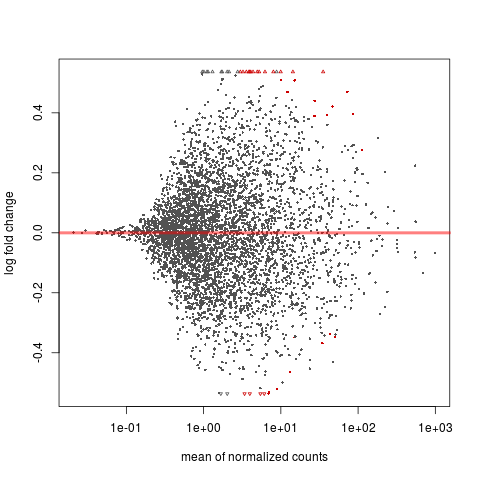

In [99]:
%%R
EnzRes = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [100]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

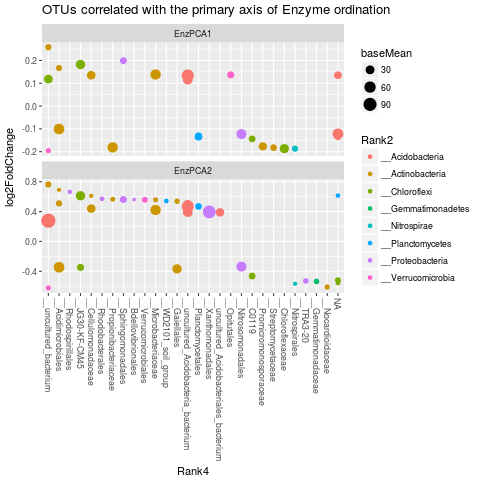

In [101]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2

In [105]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t3_sig.csv', row.names = FALSE)

In [55]:
%%R
toKeep = Year.x2.res %>% as.data.frame %>% mutate(OTU = rownames(Year.x2.res)) %>% filter(padj < 0.05) %>% .$OTU

In [64]:
%%R -i workDir
#use non-sqrt transformed relative abundances for clarity of interpretation



ToPlot = physeq.plant.t2 %>%
        transform_sample_counts(., function (x) x/sum(x)) %>%
        prune_taxa(toKeep, .) %>%
        
        psmelt()
        

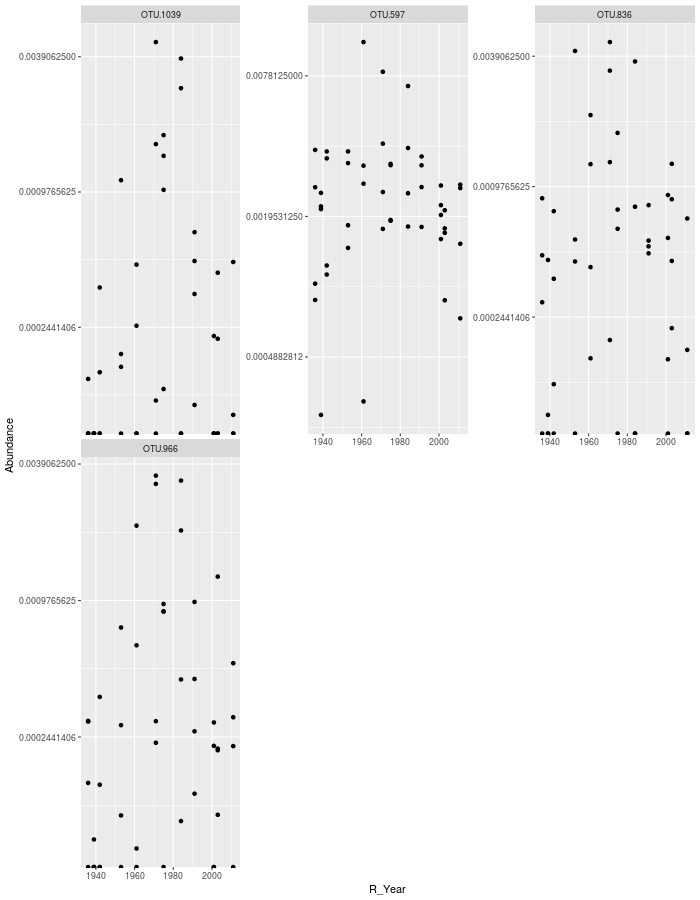

In [65]:
%%R -w 700 -h 900
require(scales)
p = ggplot(ToPlot, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 3)+
        scale_y_continuous(trans=log2_trans())
p

In [60]:
%%R
ToPlot %>%
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>%
    unique %>% print

PolyTaxa = ToPlot %>% .$OTU %>% unique

         OTU            Rank2                 Rank3             Rank4
60   OTU.597 __Proteobacteria __Gammaproteobacteria __Xanthomonadales
25  OTU.1039    __Chloroflexi        __Anaerolineae  __Anaerolineales
126  OTU.836    __Chloroflexi        __Anaerolineae  __Anaerolineales
147  OTU.966    __Chloroflexi        __Anaerolineae  __Anaerolineales
                 Rank5        Rank6                  Rank7
60  __Xanthomonadaceae __uncultured __uncultured_bacterium
25   __Anaerolineaceae __uncultured __uncultured_bacterium
126  __Anaerolineaceae __uncultured __uncultured_bacterium
147  __Anaerolineaceae __uncultured __uncultured_bacterium


In [61]:
%%R
mat = ToPlot %>%
    group_by(OTU, Rank2, Rank5, Rank6, Plant, R_Year) %>%
    summarize(mAbund = mean(Abundance)) %>%
    as.data.frame() %>%
       mutate(Taxa = paste(OTU, ":_", Rank5, "_", Rank6, sep = "")) %>%
    select(Taxa, R_Year, mAbund) %>%
    spread(R_Year,mAbund) 

rownames(mat) = mat$Taxa
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                                          1936  1939  1942 1953  1961  1971
OTU.1039:___Anaerolineaceae___uncultured  0.25  0.00  1.00  1.5  1.00  7.00
OTU.597:___Xanthomonadaceae___uncultured 10.75 10.25 22.50 14.0 22.50 26.75
OTU.836:___Anaerolineaceae___uncultured   2.25  0.75  2.00  5.5  5.75 12.75
OTU.966:___Anaerolineaceae___uncultured   1.00  0.25  0.75  1.5  3.75  9.50
                                          1975  1984  1991  2001 2003  2011
OTU.1039:___Anaerolineaceae___uncultured  8.50  8.25  3.50  0.50 0.75  0.75
OTU.597:___Xanthomonadaceae___uncultured 20.50 21.75 25.25 16.25 8.00 11.25
OTU.836:___Anaerolineaceae___uncultured   5.75  8.75  5.25  3.00 3.00  2.00
OTU.966:___Anaerolineaceae___uncultured   5.25  6.75  3.50  0.75 1.50  1.75


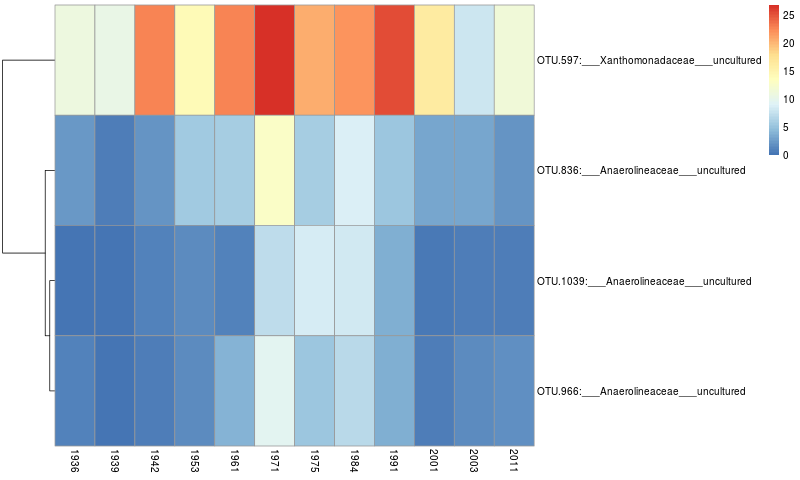

In [62]:
%%R -w 800
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

# l2fc at T3

In [176]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
sample_data(physeq.plant.t3)$Plant = relevel(sample_data(physeq.plant.t3)$Plant, "330" )
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)


In [177]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t3, ~ Rep + Fert + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")



In [178]:
%%R
resultsNames(diagdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "Fert0"        "Fert85"       "Fert170"      "Plant330"     "Plant3475"   
[11] "Plant34M95"   "Plant3517"    "Plant354"     "PlantP1151HR"


In [179]:
%%R
Plants = sample_data(physeq.plant.t3)$Plant %>% levels %>% .[2:6]
Plants

[1] "3475"    "34M95"   "3517"    "354"     "P1151HR"


In [180]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "330"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [181]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T3"
df_plant.t3 = df_plant

t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t3 = left_join(df_plant.t3, t.df, by = "OTU")

In [182]:
%%R
df_plant.t3 %>% head

    baseMean log2FoldChange     lfcSE    pvalue padj       OTU Plant TimePoint
1  7.0919597      0.3936002 0.2854371 0.1679137    1   OTU.871  3475        T3
2  0.5654074     -0.5269250 0.4234443 0.2133603    1  OTU.9547  3475        T3
3 14.6904237     -0.1372178 0.2024182 0.4978398    1   OTU.523  3475        T3
4  2.9451143      0.2389038 0.3665647 0.5145707    1  OTU.1107  3475        T3
5  1.1655532      0.4116360 0.4292826 0.3376128    1 OTU.11742  3475        T3
6  2.4309638     -0.2579230 0.3700681 0.4858273    1  OTU.1889  3475        T3
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxoc

## normalized depth at each time point

In [210]:
%%R
df_plant.t1 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T1") %>% print

df_plant.t2 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T2") %>% print

df_plant.t3 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T3") %>% print

[1] "30141.0035102652 normalized reads at T1"
[1] "32543.8985184371 normalized reads at T2"
[1] "33535.0243078956 normalized reads at T3"


In [ ]:
# Join timepoints

In [183]:
%%R
df_all = bind_rows(df_plant.t1, df_plant.t2, df_plant.t3)

In [184]:
%%R -i workDir


write.csv(df_all, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv", row.names = FALSE, sep = ",")

# Graph changes at T2

In [185]:
%%R
df.l2fc = read.csv("/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv", header = TRUE)

In [186]:
%%R
head(df.l2fc)

    baseMean log2FoldChange     lfcSE    pvalue padj       OTU Plant TimePoint
1  8.7507877    0.142186210 0.2720088 0.6011645    1   OTU.871   354        T1
2  0.3159718   -0.050914616 0.2646183 0.8474228    1  OTU.9547   354        T1
3 15.8508860    0.005701919 0.2331705 0.9804906    1   OTU.523   354        T1
4  2.2112584   -0.356657463 0.3738225 0.3400420    1  OTU.1107   354        T1
5  1.0661659   -0.033434869 0.4072093 0.9345614    1 OTU.11742   354        T1
6  3.2391696   -0.402978411 0.3715884 0.2781541    1  OTU.1889   354        T1
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxoc

In [187]:
%%R
YR = sample_data(physeq.Full) %>%
    filter(SeedTreatment != "Untreated" & Plant != "Bare") %>%
    as.data.frame() %>%
    select(Plant, R_Year) %>%
    unique %>% 
    filter(Plant!= "322")

YR


     Plant R_Year
1  P1151HR   2011
2    34M95   2001
3      330   1939
4      354   1953
5     3517   1971
6     3475   1984
7     3541   1975
8     3618   1961
9     3394   1991
10   34N42   2003
11     339   1942


In [188]:
%%R
DF = df.l2fc %>% filter(TimePoint == "T2")  %>% as.data.frame()
DF = left_join(DF, YR, by = "Plant")
DF =  mutate(DF, Plant = reorder(Plant,R_Year))
levels(DF$Plant)

 [1] "330"     "339"     "354"     "3618"    "3517"    "3541"    "3475"   
 [8] "3394"    "34M95"   "34N42"   "P1151HR"


In [189]:
%%R
DF$R_Year %>% unique

 [1] 1939 1942 1991 1984 2001 2003 1971 1953 1975 1961 2011


In [190]:
%%R
# Identify top 9 phyla to graph
Phy_toKeep = physeq.plant %>% 
    psmelt() %>%
    group_by(Rank2) %>%
    summarize(Phy_Abund = sum(Abundance)) %>%
    arrange(desc(Phy_Abund)) %>%
    as.data.frame() %>%
    .[1:9,] %>%
    .$Rank2 

In [191]:
%%R
Phy_toKeep

[1] __Actinobacteria   __Proteobacteria   __Acidobacteria    __Chloroflexi     
[5] __Planctomycetes   __Verrucomicrobia  __Bacteroidetes    __Gemmatimonadetes
[9] __Firmicutes      
29 Levels: __Acidobacteria __Actinobacteria ... __WCHB1-60


In [192]:
%%R
# Identify phyla to remove from figure by low base mean and low l2f
# Phy_toKeep = DF %>% group_by(Rank2) %>%
#     summarize(Filter = max(baseMean < 20) & max(abs(log2FoldChange)) < 1 ) %>%
#     filter(Filter == FALSE) %>%
#     .[,"Rank2"] %>% 
#     as.list()


#

DF.p = filter(DF, Rank2 %in% Phy_toKeep & !is.na(R_Year))
DF.p$Rank2 = droplevels(DF.p$Rank2)
#DF.p$R_Year = droplevels(DF.p$R_Year)

In [193]:
%%R
head(DF.p)

    baseMean log2FoldChange     lfcSE     pvalue padj       OTU Plant TimePoint
1  6.7818683    -0.89676535 0.5437824 0.09912196    1   OTU.871   330        T2
2  0.5462976    -0.38256122 0.4414269 0.38613558    1  OTU.9547   330        T2
3 15.7235779    -0.08419484 0.3373967 0.80294110    1   OTU.523   330        T2
4  2.9545293     0.35363727 0.6034456 0.55785530    1  OTU.1107   330        T2
5  0.8649499     0.09464643 0.6198999 0.87865050    1 OTU.11742   330        T2
6  1.8121440     0.49468076 0.6291017 0.43167489    1  OTU.1889   330        T2
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria 

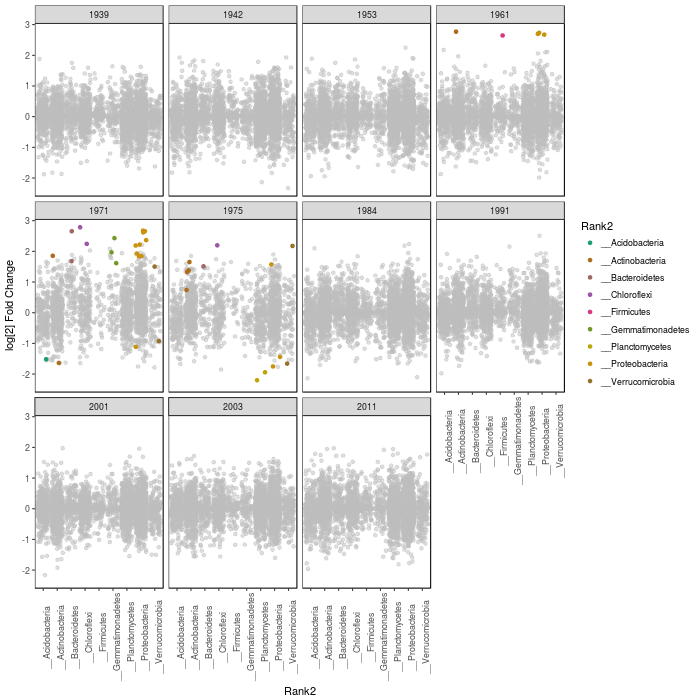

In [194]:
%%R -w 700 -h 700


#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = DF.p %>% filter(padj < 0.05)
df.ns = DF.p %>% filter(padj >= 0.05)

colourCount = length(unique(DF.p$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(DF.p)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange), color = "Grey", alpha = 0.5, position = "jitter") +
    scale_shape_identity() +
       geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2),position = "jitter") +
               #geom_hline(y_intercept = .4) +
    facet_wrap(~R_Year)+
    theme_pub() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
p

In [195]:
%%R
 df.sig$OTU %>% unique %>% length
#df.sig

[1] 38


## Create metrics and tables by timepoint

In [197]:
%%R

# Explore rhizosphere responders after multiple comparison correction across all comps
sig = df_all %>% filter(padj < 0.05 )

print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", 
            sig$OTU %>% unique %>% length, sep = ""))

sig.t1 = df_all %>% filter(padj < 0.05 & TimePoint == "T1")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t1$OTU %>% unique %>% length, sep = ""))

sig.t2 = df_all %>% filter(padj < 0.05  & TimePoint == "T2")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t2$OTU %>% unique %>% length, sep = ""))

sig.t3 = df_all %>% filter(padj < 0.05 &   TimePoint == "T3")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t3$OTU %>% unique %>% length, sep = ""))


[1] "OTUs differentially abundant from earlierst hybrid sampled: 48"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 6"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 38"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 4"


In [198]:
%%R
sig.t1 

   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1  7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  3517
2 13.174639      -1.642173 0.3937016 3.031173e-05 0.024764686 OTU.11534  3517
3  9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  3517
4  6.898065       1.491062 0.3472081 1.751406e-05 0.024764686   OTU.808  3517
5  3.337030      -1.662755 0.3549319 2.803505e-06 0.006372368   OTU.948 34M95
6 12.065722      -1.557657 0.3803000 4.205950e-05 0.047800621   OTU.399 34M95
  TimePoint    Rank1            Rank2                 Rank3
1        T1 Bacteria __Proteobacteria  __Betaproteobacteria
2        T1 Bacteria __Proteobacteria __Gammaproteobacteria
3        T1 Bacteria __Proteobacteria __Gammaproteobacteria
4        T1 Bacteria __Actinobacteria __Propionibacteriales
5        T1 Bacteria __Proteobacteria __Alphaproteobacteria
6        T1 Bacteria __Proteobacteria  __Betaproteobacteria
                   Rank4          

In [199]:
%%R
write.csv(sig.t1, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t1.csv")

In [201]:
%%R
sig.t2 = sig.t2 %>%
    arrange(Rank2,log2FoldChange)

In [202]:
%%R
write.csv(sig.t2, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t2.csv")
write.csv(sig.t3, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t3.csv")

In [ ]:
## Plot counts of those OTUs differentially abundant at T1

In [167]:
%%R
phy.snorm = readRDS("/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds")
phy.snorm = subset_samples(phy.snorm, SeedTreatment == "Treated"& TimePoint != "T0" )
phy.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [170]:
# %%R
# # prune phyloseq object to just differentially abundant taxa
# ToKeep = sig$OTU 

# phy.dif = prune_taxa(ToKeep, phy.snorm)
# phy.dif

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 25 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 25 tips and 24 internal nodes ]


In [182]:
%%R
ToKeep = sig.t1$OTU
mdf.t1 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t1)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [2]

   Plant R_Year       OTU       mAbund      seAbund
  <fctr>  <int>     <chr>        <dbl>        <dbl>
1    322   1936 OTU.11534 9.732498e-05 3.897666e-05
2    322   1936  OTU.3521 2.839119e-04 2.434746e-04
3    322   1936  OTU.4313 1.478318e-05 8.806521e-06
4    322   1936   OTU.808 5.910753e-05 3.077966e-05
5    322   1936   OTU.948 1.167182e-04 1.012595e-04
6    330   1939 OTU.11534 5.048774e-04 2.407976e-04


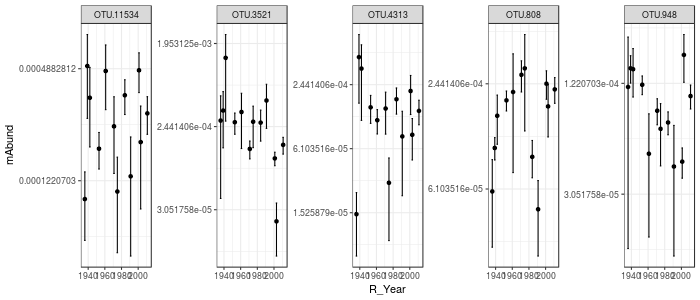

In [185]:
%%R -w 700 -h 300
pT1 = ggplot(mdf.t1, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())

## Plot OTUs differentially abundant at T2

In [156]:
%%R
ToKeep = sig.t2$OTU
mdf.t2 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t2)



Error in prune_taxa(ToKeep, phy.snorm) : object 'phy.snorm' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in prune_taxa(ToKeep, phy.snorm) : object 'phy.snorm' not found

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In write.csv(df_all, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv",  :
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  attempt to set 'sep' ignored

  warnings.warn(x, RRuntimeWarning)


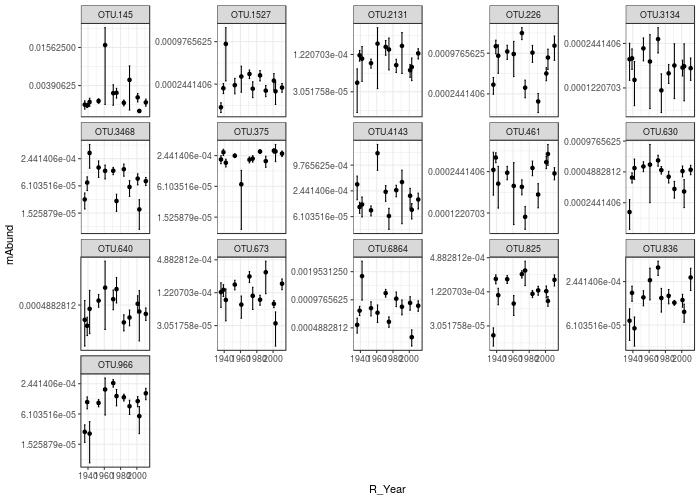

In [189]:
%%R -w 700 -h 500
pT2 = ggplot(mdf.t2, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT2

### Plot OTUs differentially abundant at T3

In [190]:
%%R
ToKeep = sig.t3$OTU
mdf.t3 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t3)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [2]

   Plant R_Year      OTU       mAbund      seAbund
  <fctr>  <int>    <chr>        <dbl>        <dbl>
1    322   1936 OTU.2053 3.368964e-04 1.157632e-04
2    322   1936 OTU.9266 4.509797e-05 3.446595e-05
3    322   1936   OTU.93 2.177639e-03 3.995815e-04
4    322   1936  OTU.950 0.000000e+00 0.000000e+00
5    330   1939 OTU.2053 4.384745e-04 3.736083e-05
6    330   1939 OTU.9266 1.279869e-04 6.994519e-05


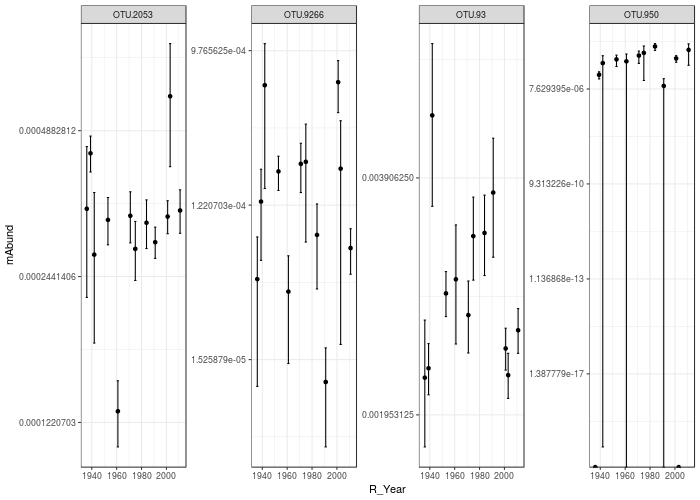

In [192]:
%%R -w 700 -h 500
pT3 = ggplot(mdf.t3, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT3

# Plot top 30 top most abundant otus

In [196]:
%%R
phy.snorm.t2 = subset_samples(phy.snorm, TimePoint == "T2", TRUE)


In [208]:
%%R
T30 = taxa_sums(phy.snorm.t2) %>% sort(decreasing = TRUE)  %>%.[1:30] %>% names()

In [213]:
%%R
ToKeep = T30
mdf.30 = prune_taxa(ToKeep, phy.snorm.t2) %>%
    psmelt() # %>%
  #  group_by(Plant, R_Year, OTU) %>%
  #   summarize(mAbund = mean(Abundance),
   #               seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.30)

        OTU         Sample  Abundance     X.sampleID TubeID ExtractionPlate
120  OTU.12 ERA-T2_1-4c_85 0.07297040 ERA-T2_1-4c_85    380            ERA1
41   OTU.10 ERA-T2_4-2c_85 0.06575421 ERA-T2_4-2c_85    458            ERA5
196  OTU.14 ERA-T2_1-2c_85 0.05279018 ERA-T2_1-2c_85    364            ERA1
72   OTU.11 ERA-T2_4-4a_85 0.04643745 ERA-T2_4-4a_85    469            ERA5
1269  OTU.5 ERA-T2_1-4c_85 0.04614713 ERA-T2_1-4c_85    380            ERA1
87   OTU.11 ERA-T2_3-3d_85 0.03936835 ERA-T2_3-3d_85    439            ERA4
     PooledDNAPlate Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X
120               A             E6           1            45             E6 NA
41                B            G12           2            95            G12 NA
196               A             D2           1            12             D2 NA
72                B            B12           2            90            B12 NA
1269              A             E6           1            45             

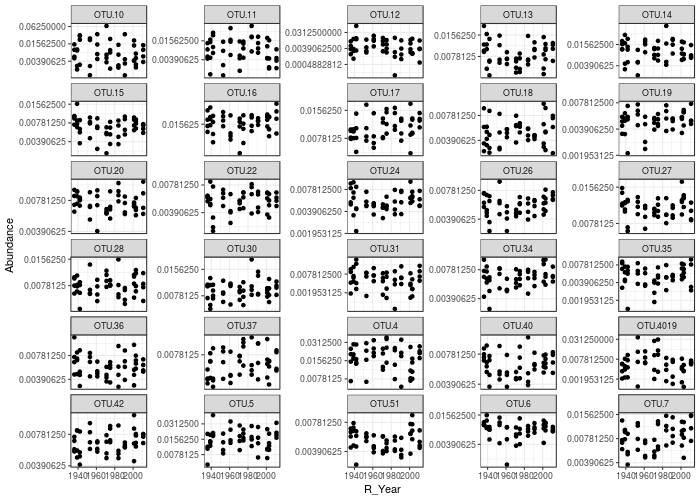

In [214]:
%%R -w 700 -h 500
pT30 = ggplot(mdf.30, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT30

# Now try plot with the 30 most abundant in any sample

In [216]:
%%R
ToKeep = psmelt(phy.snorm.t2) %>%
  group_by(OTU) %>%
  summarize(max = max(Abundance))%>%
            arrange(desc(max)) %>%
            .$OTU %>%
            .[1:30]
   #               seAbund = sd(Abundance)/sqrt(length(Abundance)))
ToKeep

 [1] "OTU.12"   "OTU.10"   "OTU.145"  "OTU.14"   "OTU.119"  "OTU.11"  
 [7] "OTU.5"    "OTU.4"    "OTU.4019" "OTU.38"   "OTU.16"   "OTU.31"  
[13] "OTU.13"   "OTU.30"   "OTU.17"   "OTU.27"   "OTU.15"   "OTU.6"   
[19] "OTU.28"   "OTU.7"    "OTU.36"   "OTU.69"   "OTU.905"  "OTU.90"  
[25] "OTU.42"   "OTU.20"   "OTU.40"   "OTU.18"   "OTU.37"   "OTU.560" 


In [217]:
%%R
T30 = prune_taxa(ToKeep, phy.snorm.t2) %>%
    psmelt()

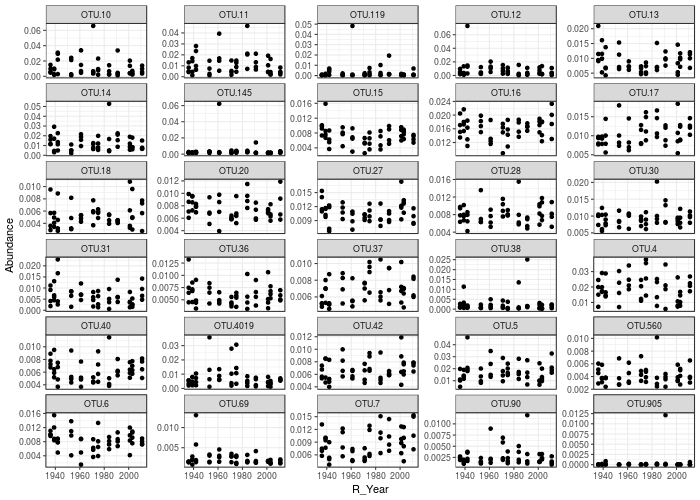

In [224]:
%%R -w 700 -h 500
pT30 = ggplot(T30, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 5) #+
       # scale_y_continuous(trans=log2_trans())
pT30